In [2]:
import re
import os
import pandas as pd
import ngrams
import numpy as np
import math
import csv

In [3]:
#全局变量
attributeList = []
#token的字典，用来记录token出现的次数nt
tokenDict={}

In [4]:
#将属性名按照标点，分割成token
def snake_case_split(line):
    #Python strip() 方法用于移除字符串头尾指定的字符（默认为空格或换行符）或字符序列。
    #r表示非转义的原始字符串
    #由于正则表达式通常都包含反斜杠，所以你最好使用原始字符串来表示它们。模式元素(如 r'\t'，等价于 '\\t')匹配相应的特殊字符。
    #[...]用来表示一组字符,单独列出：[amk] 匹配 'a'，'m'或'k'
    line_split = re.split(r'[\s_]',line.strip())
    line_split = [line.strip() for line in line_split if len(line.strip())>0]
    return line_split




#将属性按照大写字母，分割成token
#"firstName"分成 ['First', 'Name']
def camel_case_split(str):
    if "a"<=str[0]<="z" :
        strTemp=str[0].upper()+str[1:]
        return re.findall(r'[A-Z](?:[a-z]+|[A-Z]*(?=[A-Z]|$))', strTemp)
    else :
        return re.findall(r'[A-Z](?:[a-z]+|[A-Z]*(?=[A-Z]|$))', str)




#将属性名先按照snakeCase拆分，再按照camelCase拆分
def attributeToToken(str):
    tokenList = []
    for snakeToken in snake_case_split(str):
        for camelToken in camel_case_split(snakeToken):
            camelToken = camelToken.lower()
            corpusTokenList = ngrams.segment2(camelToken) [1]
            tokenList = tokenList + corpusTokenList
            for finalToken in corpusTokenList:                
                #生成token的时候就更新tokenDict
                if finalToken in tokenDict:
                    tokenDict[finalToken] = tokenDict[finalToken]+1
                else:
                    tokenDict[finalToken] = 1       
    return tokenList


In [5]:
class Attribute:
    def __init__(self, attributeName, originateFrom):
        self.attributeName = attributeName
        self.tokenList = attributeToToken(attributeName)
        #属性的词嵌入表示
        #加权平均
        #权和N有关
        #numOfAttribute得读完整个数据湖才知道
        #self.wordEmbedding = tokenToVector(self.tokenList)
        
        #属性来自哪张表
        self.originateFrom = originateFrom

In [ ]:
class Table:
    def __init__(self, ):

In [5]:
df = pd.read_csv('/usr/dataLake/datasets/BenchmarkCsvfiles/CTA_Ridership_Avg_Weekday_Bus_Stop_Boardings_in_October_2012____c5_0____1.csv')

#list函数返回一个表的所有属性，返回一个list
print(list(df))

['alightings', 'boardings', 'cross_street', 'location', 'routes']


In [6]:
numOfAttribute = 0
numOfTable = 0

#将湖中所有属性读到attributeList中

#for循环中的info代表文件名
for info in os.listdir('/usr/dataLake/datasets/BenchmarkCsvfiles'): 
    #去掉.csv后缀
    tableName = info[0:-4]
    domain = os.path.abspath('/usr/dataLake/datasets/BenchmarkCsvfiles') #获取文件夹的路径
    info = os.path.join(domain,info) #将路径与文件名结合起来就是每个文件的完整路径
    print(info)
    df = pd.read_csv(info)
    for attributeName in list(df):
        x=Attribute(attributeName, tableName)
        numOfAttribute = numOfAttribute+1
        #通过append函数将自定义类的对象放入list中
        attributeList.append(x)
        #print(attributeList[i])可证明是Attribute类的对象
    
    numOfTable = numOfTable + 1
    if numOfTable == 10:
        break

/usr/dataLake/datasets/BenchmarkCsvfiles/t_93f3d6f7fc6aa6ff____c13_0____0.csv
/usr/dataLake/datasets/BenchmarkCsvfiles/t_70941cace7dd1c45____c12_1____1.csv
/usr/dataLake/datasets/BenchmarkCsvfiles/t_e9efd5cda78af711____c4_1____1.csv
/usr/dataLake/datasets/BenchmarkCsvfiles/t_ca85e8f9eef5b9d5____c5_1____0.csv
/usr/dataLake/datasets/BenchmarkCsvfiles/t_dc9442ed0b52d69c____c13_0____4.csv
/usr/dataLake/datasets/BenchmarkCsvfiles/PED_SK_DTL_SNF____c6_0____4.csv
/usr/dataLake/datasets/BenchmarkCsvfiles/t_93f3d6f7fc6aa6ff____c21_0____4.csv
/usr/dataLake/datasets/BenchmarkCsvfiles/CTA_Ridership_Avg_Weekday_Bus_Stop_Boardings_in_October_2012____c7_0____2.csv
/usr/dataLake/datasets/BenchmarkCsvfiles/t_014c2259cce4ab13____c25_0____4.csv
/usr/dataLake/datasets/BenchmarkCsvfiles/CTA_Ridership_Avg_Weekday_Bus_Stop_Boardings_in_October_2012____c2_1____3.csv


In [7]:
#加载模型
import fasttext
fasttext.FastText.eprint = lambda x: None
model = fasttext.load_model("/usr/dataLake/result/fil9.bin")

def getTokenWeight(token):
    nt = tokenDict[token]
    #默认以e为底
    return math.log(numOfAttribute/nt)

#归一化向量
def normalize(x):
    return x/np.linalg.norm(x)

#将属性名的tokenList转换为词嵌入向量
#获取token对应的词嵌入向量，归一化。加权平均后，再归一化一下。
def tokenToVector(tokenList):
    #获取词嵌入
    wordEmbedding = model.get_word_vector(tokenList[0])
    #函数返回值
    unitVector = getTokenWeight(tokenList[0]) * normalize(wordEmbedding)
    #加权平均的分母
    totalWeight = getTokenWeight(tokenList[0])
    for token in tokenList[1:]:
        wordEmbedding = model.get_word_vector(token)
        unitVector = unitVector + getTokenWeight(token) * normalize(wordEmbedding)
        totalWeight = totalWeight+getTokenWeight(token)    
    return normalize(unitVector/totalWeight)


In [11]:
with open('attributeVector.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    for attribute in attributeList:
        attribute.wordEmbedding = tokenToVector(attribute.tokenList)
        writer.writerow(attribute.wordEmbedding)

In [10]:
len(attributeList)

108

In [8]:
print(tokenDict)

{'address': 2, 'auth': 2, 'description': 4, 'granted': 2, 'date': 9, 'lic': 2, 'no': 5, 'pub': 2, 'text': 2, 'reg': 7, 'service': 6, 'number': 2, 'type': 9, 'other': 2, 'details': 3, 'tao': 2, 'covered': 2, 'by': 2, 'area': 2, 'effective': 2, 'end': 2, 'trading': 2, 'name': 4, 'quality': 25, 'indicator': 25, 'indicateurs': 29, 'de': 29, 'qualit': 29, 'kind': 1, 'pmc': 1, 'he': 1, 'pm': 4, 'te': 4, 's': 3, 'grou': 1, 'colour': 1, 'consis': 1, 'pls': 1, 'mottle': 1, 'frq': 1, 'root': 2, 'freq': 1, 'sec': 1, 'grad': 1, 'rest': 1, 'ri': 1, 'soil': 1, 'group': 1, 'exp': 1, 'op': 1, 'registration': 1, 'status': 1, 'subsidies': 1, 'finish': 1, 'point': 2, 'received': 1, 'start': 1, 'via': 1, 'a': 1, 'lightings': 1, 'boardings': 1, 'cross': 1, 'street': 3, 'location': 2, 'on': 2, 'routes': 1, 'stop': 2, 'id': 2, 'aircraft': 6, 'make': 4, 'airport': 1, 'icao': 1, 'incident': 1, 'occ': 2, 'ocean': 1, 'operator': 2, 'organization': 5, 'country': 5}


In [9]:
print(attributeList[8].tokenList)
print(attributeList[8].wordEmbedding)
print(np.linalg.norm(attributeList[8].wordEmbedding))
print(attributeList[8].originateFrom)
print(numOfAttribute)

['service', 'type', 'other', 'details']
[ 4.99052927e-02 -1.15369272e-03  2.00742289e-01 -4.38491106e-02
  1.17201284e-01  8.15718919e-02 -8.00280049e-02  1.59513593e-01
 -2.02500567e-01 -1.02051534e-01  7.91407302e-02  2.52465960e-02
 -1.18822321e-01  1.35037024e-02 -5.05634993e-02 -1.66779220e-01
  8.83953422e-02  1.41523227e-01  4.71826224e-03 -7.99975023e-02
  1.20108239e-01  6.35233298e-02  1.26938149e-01  6.46374896e-02
 -8.48486796e-02 -1.54228965e-02 -3.02484389e-02  9.51124821e-03
 -3.88216376e-02  6.81806058e-02  5.53127006e-03  1.19844461e-02
  1.85125560e-01 -2.16972586e-02 -1.89874336e-01  7.05159530e-02
  5.34744784e-02 -1.48780737e-02  2.37860009e-02  8.09602663e-02
  2.32513860e-01  5.54126427e-02  2.85403877e-02 -2.36775354e-02
  1.89561043e-02 -1.91506684e-01  3.88298668e-02  5.75303771e-02
  2.17782855e-01 -7.10429624e-02 -1.60020217e-02 -1.24431234e-02
 -1.19365724e-02 -1.16756596e-01  8.47585872e-02 -1.34473620e-02
 -9.02329162e-02 -5.49329538e-03 -1.54544473e-01  

In [13]:
fenzi=math.log(108/6)*normalize(model.get_word_vector("service"))+math.log(108/9)*normalize(model.get_word_vector("type"))+math.log(108/2)*normalize(model.get_word_vector("other"))+math.log(108/3)*normalize(model.get_word_vector("details"))
fenmu=math.log(108/6)+math.log(108/9)+math.log(108/2)+math.log(108/3)
print(normalize(fenzi/fenmu))

[ 4.99052927e-02 -1.15369272e-03  2.00742289e-01 -4.38491106e-02
  1.17201284e-01  8.15718919e-02 -8.00280049e-02  1.59513593e-01
 -2.02500567e-01 -1.02051534e-01  7.91407302e-02  2.52465960e-02
 -1.18822321e-01  1.35037024e-02 -5.05634993e-02 -1.66779220e-01
  8.83953422e-02  1.41523227e-01  4.71826224e-03 -7.99975023e-02
  1.20108239e-01  6.35233298e-02  1.26938149e-01  6.46374896e-02
 -8.48486796e-02 -1.54228965e-02 -3.02484389e-02  9.51124821e-03
 -3.88216376e-02  6.81806058e-02  5.53127006e-03  1.19844461e-02
  1.85125560e-01 -2.16972586e-02 -1.89874336e-01  7.05159530e-02
  5.34744784e-02 -1.48780737e-02  2.37860009e-02  8.09602663e-02
  2.32513860e-01  5.54126427e-02  2.85403877e-02 -2.36775354e-02
  1.89561043e-02 -1.91506684e-01  3.88298668e-02  5.75303771e-02
  2.17782855e-01 -7.10429624e-02 -1.60020217e-02 -1.24431234e-02
 -1.19365724e-02 -1.16756596e-01  8.47585872e-02 -1.34473620e-02
 -9.02329162e-02 -5.49329538e-03 -1.54544473e-01  1.07101090e-01
  7.43038803e-02  1.47523

In [ ]:
#nt小，ITF大，权重大。
#token越稀有，权重越大。
#N是数据湖中有多少列。

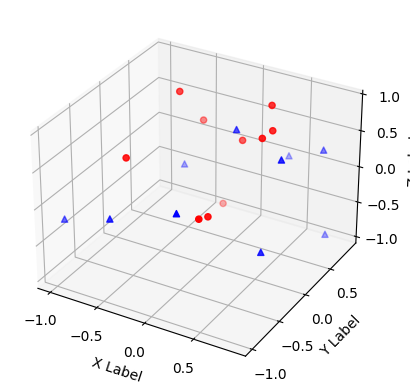

In [7]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
 
 
def randrange(n, vmin, vmax):
    '''
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    '''
    return (vmax - vmin)*np.random.rand(n) + vmin
 #np.random.rand(n)产生1*n数组，元素大小0-1
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
 
n = 10
 
# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for c, m, zlow, zhigh in [('r', 'o', -1, 1), ('b', '^', -1, 1)]:
    xs = randrange(n, -1, 1)
    ys = randrange(n, -1, 1)
    zs = randrange(n, zlow, zhigh)
    ax.scatter(xs, ys, zs, c=c, marker=m)
 
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [26]:
n=50
def randrange(n, vmin, vmax):
    '''
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    '''
    return (vmax - vmin)*np.random.rand(n) + vmin
 #np.random.rand(n)产生1*n数组，元素大小0-1

xs = randrange(n, -1, 1)
ys = randrange(n, -1, 1)
#zs = randrange(n, -1, 1)

for i in range(0,n):
    print(xs[i], end="")
    print(',', end="")
    print(ys[i])
    #print(ys[i], end="")
    #print(',', end="")
    #print(zs[i])




0.5896874841963256,-0.8753924854220463
0.6717849441158124,-0.050472327987783894
0.9688565758768888,-0.6532609523517481
-0.45441991479203714,0.7697222405586119
-0.35257521527039315,0.20796117811720216
-0.6425602012520255,0.4627906166585536
0.09887745530125569,-0.3773220487688065
-0.6690964784859896,-0.6970731049221761
-0.10103100343706961,0.31584915133389835
-0.35210994734805934,-0.5350722796487621
0.47870505920188977,0.35210748715907725
0.2156235745507975,-0.0973537906301658
0.9264712410491942,0.5331031462896354
0.8474124145385802,0.2601298364967011
-0.6736799765958033,0.8907009494949776
-0.9859444399687918,0.5883175741395856
0.12918894534865588,0.37286687181883416
0.3520194516840187,-0.605916383055408
-0.8245175924220054,-0.28430790010655715
-0.09583385781135556,0.7428892466724868
-0.7246680212924028,0.9797718247734839
0.09106068254205968,-0.4289627652235186
-0.704438122037766,0.03940964777306166
-0.8617616019340353,-0.9352037572257508
-0.7402084440461154,0.6119274412542663
-0.7009111

In [27]:
#以上向量的label
labels=[]
with open("/usr/dataLake/DRD/ball-k-means/test.txt", "r") as tf:
    lines = tf.read().split('\n')
    
for line in lines:

    labels.append(int(line))

print(labels)

[1, 1, 1, 2, 2, 2, 0, 0, 2, 0, 1, 1, 1, 1, 2, 2, 2, 1, 0, 2, 2, 0, 2, 0, 2, 0, 0, 1, 2, 0, 0, 2, 1, 0, 0, 2, 2, 1, 2, 1, 0, 0, 0, 2, 0, 1, 0, 1, 2, 0]


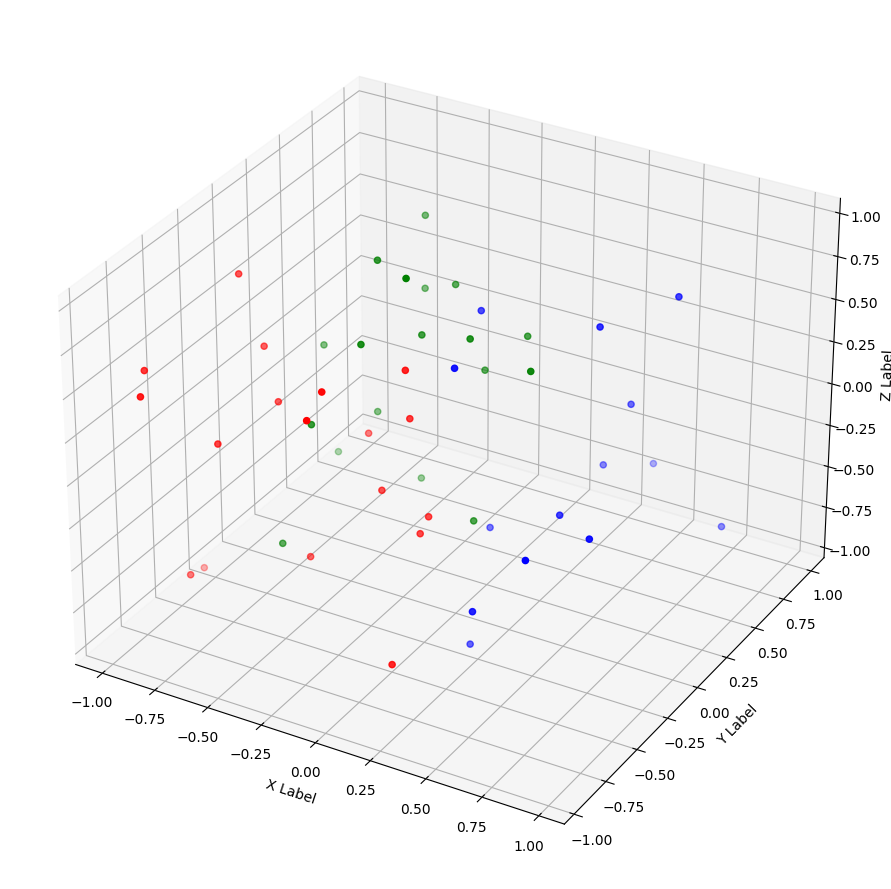

In [33]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
xl0=[]
xl1=[]
xl2=[]
yl0=[]
yl1=[]
yl2=[]
zl0=[]
zl1=[]
zl2=[]
for i in range(0,n):
    if labels[i]==0:
        xl0.append(xs[i])
        yl0.append(ys[i])
        zl0.append(zs[i])
    elif labels[i]==1:
        xl1.append(xs[i])
        yl1.append(ys[i])
        zl1.append(zs[i])
    else:
        xl2.append(xs[i])
        yl2.append(ys[i])
        zl2.append(zs[i])



fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xl0, yl0, zl0, c='r', marker='o')
ax.scatter(xl1, yl1, zl1, c='b', marker='o')
ax.scatter(xl2, yl2, zl2, c='g', marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.tight_layout()
plt.show()

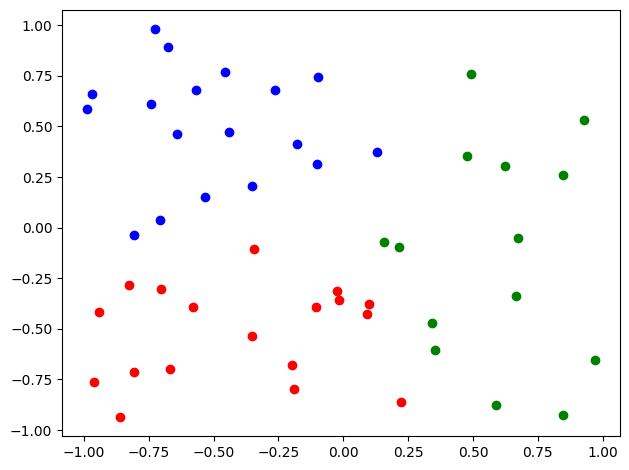

In [32]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
xl0=[]
xl1=[]
xl2=[]
yl0=[]
yl1=[]
yl2=[]

for i in range(0,n):
    if labels[i]==0:
        xl0.append(xs[i])
        yl0.append(ys[i])

    elif labels[i]==1:
        xl1.append(xs[i])
        yl1.append(ys[i])

    else:
        xl2.append(xs[i])
        yl2.append(ys[i])

fig=plt.figure() #创建画布
ax=plt.subplot(1,1,1)
plt.plot(xl0,yl0,'or')
plt.plot(xl1,yl1,'og')
plt.plot(xl2,yl2,'ob')
plt.tight_layout()
plt.show()

In [29]:
from ast import Num
from ctypes import *
import numpy as np

lib = CDLL("/usr/dataLake/DRD/ball-k-means/libballkmeans.so")

#array = np.array(np.arange(5), dtype=np.int64)
lib.ybc_k_means.restype = c_void_p
#array_buffer = array.tobytes()

ret = lib.ybc_k_means()

ret_buffer = string_at(ret, len(int)*n)
ret_array = np.frombuffer(ret_buffer, dtype=int)
print(ret_array)

AttributeError: /usr/dataLake/DRD/ball-k-means/libballkmeans.so: undefined symbol: ybc_k_means

In [4]:
from ctypes import *
import numpy as np

lib = CDLL("./libmul_array.so")
array = np.array(np.arange(5), dtype=np.int64)
lib.mul_array.restype = c_void_p
print(array)
array_buffer = array.tobytes()
ret = lib.mul_array(array_buffer, array.size)
ret_buffer = string_at(ret, len(array_buffer))
ret_array = np.frombuffer(ret_buffer, dtype=array.dtype)
print(ret_array)


[0 1 2 3 4]
[0 2 4 6 8]
